# Hybrid CNN - CRF semantic segmentation

> Written by Dr Daniel Buscombe, Northern Arizona University

> Part of a series of notebooks for image recognition and classification using deep convolutional neural networks

This notebook demonstrates a method to use a DCNN retrained on a particular dataset (library of image tiles), and apply it to an input image for semantic segmentation

The approach taken is to classify small tiles of the input image using the DCNN, then estimate the class for the rest of the image pixels using a conditional random field

Implements the technique outlined by [Buscombe & Ritchie (2018)](http://www.mdpi.com/2076-3263/8/7/244)

![](figs/dl_tools_semseg.png)

### Load libraries

In [1]:
from __future__ import division
import os, time, sys
from glob import glob
from scipy.misc import imread

#numerical
import tensorflow as tf
import numpy as np
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import create_pairwise_bilateral, unary_from_labels, unary_from_softmax
from numpy.lib.stride_tricks import as_strided as ast
import random, string

import warnings
warnings.filterwarnings("ignore")

# suppress divide and invalid warnings
np.seterr(divide='ignore')
np.seterr(invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

plotting libraries:

In [2]:
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
from scipy.misc import imresize
import matplotlib.pyplot as plt

### Define subfunctions

Functions for tiling images into windows and loading the computational graph

In [3]:
# =========================================================
def norm_shape(shap):
   '''
   Normalize numpy array shapes so they're always expressed as a tuple,
   even for one-dimensional shapes.
   '''
   try:
      i = int(shap)
      return (i,)
   except TypeError:
      # shape was not a number
      pass

   try:
      t = tuple(shap)
      return t
   except TypeError:
      # shape was not iterable
      pass

   raise TypeError('shape must be an int, or a tuple of ints')


# =========================================================
# Return a sliding window over a in any number of dimensions
# version with no memory mapping
def sliding_window(a,ws,ss = None,flatten = True):
    '''
    Return a sliding window over a in any number of dimensions
    '''
    if None is ss:
        # ss was not provided. the windows will not overlap in any direction.
        ss = ws
    ws = norm_shape(ws)
    ss = norm_shape(ss)
    # convert ws, ss, and a.shape to numpy arrays
    ws = np.array(ws)
    ss = np.array(ss)
    shap = np.array(a.shape)
    # ensure that ws, ss, and a.shape all have the same number of dimensions
    ls = [len(shap),len(ws),len(ss)]
    if 1 != len(set(ls)):
        raise ValueError(\
        'a.shape, ws and ss must all have the same length. They were %s' % str(ls))

    # ensure that ws is smaller than a in every dimension
    if np.any(ws > shap):
        raise ValueError(\
        'ws cannot be larger than a in any dimension.\
 a.shape was %s and ws was %s' % (str(a.shape),str(ws)))
    # how many slices will there be in each dimension?
    newshape = norm_shape(((shap - ws) // ss) + 1)
    # the shape of the strided array will be the number of slices in each dimension
    # plus the shape of the window (tuple addition)
    newshape += norm_shape(ws)
    # the strides tuple will be the array's strides multiplied by step size, plus
    # the array's strides (tuple addition)
    newstrides = norm_shape(np.array(a.strides) * ss) + a.strides
    a = ast(a,shape = newshape,strides = newstrides)
    if not flatten:
        return a
    # Collapse strided so that it has one more dimension than the window.  I.e.,
    # the new array is a flat list of slices.
    meat = len(ws) if ws.shape else 0
    firstdim = (np.product(newshape[:-meat]),) if ws.shape else ()
    dim = firstdim + (newshape[-meat:])
    # remove any dimensions with size 1
    #dim = filter(lambda i : i != 1,dim)

    return a.reshape(dim), newshape

# =========================================================
def load_graph(model_file):
  graph = tf.Graph()
  graph_def = tf.GraphDef()

  with open(model_file, "rb") as f:
    graph_def.ParseFromString(f.read())
  with graph.as_default():
    tf.import_graph_def(graph_def)

  return graph

Below is the function that actually does the prediction

1. The image is fed into the classifier
2. The probability of each class is predicted (```results```)
3. They are reordered from best to worst
4. The function returns
    * the numeric code of class with the highest probability
    * the probability of that prediction
    * a vector of probabilities in order from highest to lowest

In [4]:
# =========================================================
def getCP(tmp, graph):

   input_name = "import/Placeholder" #input" 
   output_name = "import/final_result" 

   input_operation = graph.get_operation_by_name(input_name);
   output_operation = graph.get_operation_by_name(output_name);

   with tf.Session(graph=graph) as sess:
      results = sess.run(output_operation.outputs[0],
                      {input_operation.outputs[0]: np.expand_dims(tmp, axis=0)})
   results = np.squeeze(results)

   # Sort to show labels of first prediction in order of confidence
   top_k = results.argsort()[-len(results):][::-1]

   return top_k[0], results[top_k[0]] ##, results[top_k] #, np.std(tmp[:,:,0])


The image is normalized so it is less sensitive to brightness

In [5]:
# =========================================================
def norm_im(img): 
   input_mean = 0 #128
   input_std = 255 #128

   input_name = "file_reader"
   output_name = "normalized"
   nx, ny, nz = np.shape(img)

   theta = np.std(img).astype('int')
   float_caster = tf.cast(img, tf.float32)
   
   dims_expander = tf.expand_dims(float_caster, 0);
   normalized = tf.divide(tf.subtract(dims_expander, [input_mean]), [input_std])
   sess = tf.Session()
   return np.squeeze(sess.run(normalized))

The CRF function

In [6]:
# =========================================================
def getCRF(image, Lc, theta, n_iter, label_lines, compat_spat=12, compat_col=40, scale=5, prob=0.5):

      H = image.shape[0]
      W = image.shape[1]

      d = dcrf.DenseCRF2D(H, W, len(label_lines)+1)
      U = unary_from_labels(Lc.astype('int'), len(label_lines)+1, gt_prob= prob)

      d.setUnaryEnergy(U)

      del U

      # This potential penalizes small pieces of segmentation that are
      # spatially isolated -- enforces more spatially consistent segmentations
      # This adds the color-independent term, features are the locations only.
      # sxy = The scaling factors per dimension.
      d.addPairwiseGaussian(sxy=(theta,theta), compat=compat_spat, kernel=dcrf.DIAG_KERNEL, #compat=6
                      normalization=dcrf.NORMALIZE_SYMMETRIC)

      # sdims = The scaling factors per dimension.
      # schan = The scaling factors per channel in the image.
      # This creates the color-dependent features and then add them to the CRF
      feats = create_pairwise_bilateral(sdims=(theta, theta), schan=(scale, scale, scale), #11,11,11
                                  img=image, chdim=2)

      del image

      d.addPairwiseEnergy(feats, compat=compat_col, #20
                    kernel=dcrf.DIAG_KERNEL,
                    normalization=dcrf.NORMALIZE_SYMMETRIC)
      del feats

      Q = d.inference(n_iter)

      return np.argmax(Q, axis=0).reshape((H, W)) 


## Semantic segmentation of Lake Ontario shoreline imagery

### Setting up the analysis

Labels and tensorflow graph

In [7]:
labels_path = 'ontario_labels.txt'  
classifier_file = 'ontario_test_mobilenetv2_224_1000_0.01.pb'

Next, we need to define a file that contains colors for each class in the labels file.

First, let's remind ourselves of the labels

In [8]:
cat ontario_labels.txt

anthro
sediment
terrain
veg
water


The program wants as input a set of colors for each label. This is for plotting purposes

It really helps to colorize labels in an intuitive way, e.g. water = blue. 

Let's define colors in the correct order

In [9]:
cols = ['r', 'w', 'm', 'g', 'b']

In [10]:
!rm ontario_colors.txt
with open('ontario_colors.txt', 'a') as the_file:
    for c in cols:
        the_file.write(c+'\n')

In [11]:
colors_path = 'ontario_colors.txt'    

In [12]:
!cat $colors_path

r
w
m
g
b


We can also use html codes for more custom colors

https://www.w3schools.com/colors/colors_picker.asp

https://www.w3schools.com/colors/colors_names.asp

In [13]:
!rm $colors_path
cols = ['#A52A2A', '#FFD700', '#808000', '#00FF7F', '#4682B4']

with open('ontario_colors.txt', 'a') as the_file:
    for c in cols:
        the_file.write(c+'\n')
        
!cat $colors_path        

#A52A2A
#FFD700
#808000
#00FF7F
#4682B4


This next part loads the labels and colors and creates a colormap for plotting

In [14]:
## Loads label file, strips off carriage return
labels = [line.rstrip() for line 
                in tf.gfile.GFile(labels_path)]

code= {}
for label in labels:
   code[label] = [i for i, x in enumerate([x.startswith(label) for x in labels]) if x].pop()

with open(colors_path) as f: #'labels.txt') as f:
   cols = f.readlines()
cmap1 = [x.strip() for x in cols] 
 
classes = dict(zip(labels, cmap1))

cmap1 = colors.ListedColormap(cmap1)

In [15]:
classes

{'anthro': '#A52A2A',
 'sediment': '#FFD700',
 'terrain': '#808000',
 'veg': '#00FF7F',
 'water': '#4682B4'}

### Read file (S3)

The ontario dataset sits on S3. Let's load an image in

In [16]:
import s3fs
fs = s3fs.S3FileSystem(anon=True)
testimage = fs.ls('esipfed/cdi-workshop/semseg_data/ontario/test/')[0]
with fs.open(testimage, 'rb') as f:
    img = imread(f)

### Run analysis

User-defined settings

In [17]:
tile = 224 ## the size of the tile (corresponds to the size used to train the model)
winprop = 1.0 # the proportion of each tile to use as input to the CRF
prob_thres = 0.5 # threshold probability. Below this, DCNN classifications are ignored
n_iter = 30 # number of iterations in CRF model
compat_col = 100 # compatibility function (color)
theta = 60 #std deviation terms (color and spatial)
scale = 1 # weight term in CRF
decim = 2 #8 # 1/proportion of image to use in DCNN
fct =  0.25 # scale of image to use. If <1, image will be downsclaed to that fraction
compat_spat = 5 #compatability function (spatial)
prob = 0.5 # the likelihood of the CRF unary potentials

Let's explore these settings a little

* ```tile```: you should use a tile size that is the same as the tile size you used to train the model you intend to run
* ```winprop```: this is usually 1.0 unless you have a specific reason to assign the classification to less than the portion of the image represented by a tile
* ```prob_thres```: the higher this number, the fewer DCNN classifications are used
* ```prob```: the probability of the DCNN prediction. This is used by the CRF but doesn't usually matter to the final result that much
* ```n_iter```: the higher this number, the longer it takes for the CRF portion of the procedure to run, but larger numbers of iterations might result in more refined/accurate predictions
* ```compat_col```: label compatibilities for the colour-dependent term in the CRF model. Controls the minimum distance (in colorspace) between two nodes in the model that are assigned different labels  
* ```compat_spat```: label compatibilities for the spatial-dependent term in the CRF model. Controls the minimum distance (in space) between two nodes in the model that are assigned different labels  
* ```scale```: a kernel weighting term in the CRF. Always 1 unless you a have a specific reason to weight color and space differently
* ```theta```:  controls the degree of allowable similarity in image intensity between CRF graph nodes. Larger = more dissimilarity is tolerated. Relatively large means image features with relatively large differences in intensity are assigned the same label
* ```decim```: typically, you don't need to predict the class of every tile in the image. This number controls the decimation. 2 = use every second tile, 4 = every 4th tile, etc
* ```fct```: to save time during the CRF phase, the image is downscaled (the rescaled back up to the original size). This number controls the scaling: 0.5 means half the original size, 0.25 means a quarter, etc

I've broken this down into stages so it's easier to follow

Step 1: Normalize image

In [18]:
nxo, nyo, nzo = np.shape(img)
result = norm_im(img)

Step 2: Pad image using mirroring and create tiles by using sliding window. The image padding helps us deal with image boundary effects

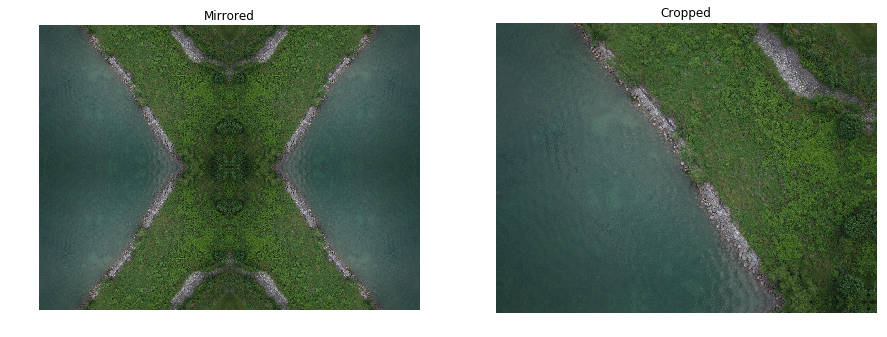

In [19]:
## pad image so it is divisible by N windows with no remainder 
result = np.vstack((np.hstack((result,np.fliplr(result))), np.flipud(np.hstack((result,np.fliplr(result))))))

plt.figure(figsize=(15,10))
plt.subplot(121); plt.imshow(result); plt.axis('off'); plt.title('Mirrored')

result = result[:nxo+np.mod(nxo,tile),:nyo+np.mod(nyo,tile), :]

plt.subplot(122); plt.imshow(result); plt.axis('off'); plt.title('Cropped')

nx, ny, nz = np.shape(result)

gridy, gridx = np.meshgrid(np.arange(ny), np.arange(nx))
Zx,_ = sliding_window(gridx, (tile,tile), (tile,tile))
Zy,_ = sliding_window(gridy, (tile,tile), (tile,tile))

Step 3: Load graph and partition image into tiles

In [20]:
if decim>1:
   Zx = Zx[::decim]
   Zy = Zy[::decim]

graph = load_graph(classifier_file)

w1 = []
Z,ind = sliding_window(result, (tile,tile,3), (tile, tile,3))
if decim>1:
   Z = Z[::decim]

Let's take a look at some of those tiles

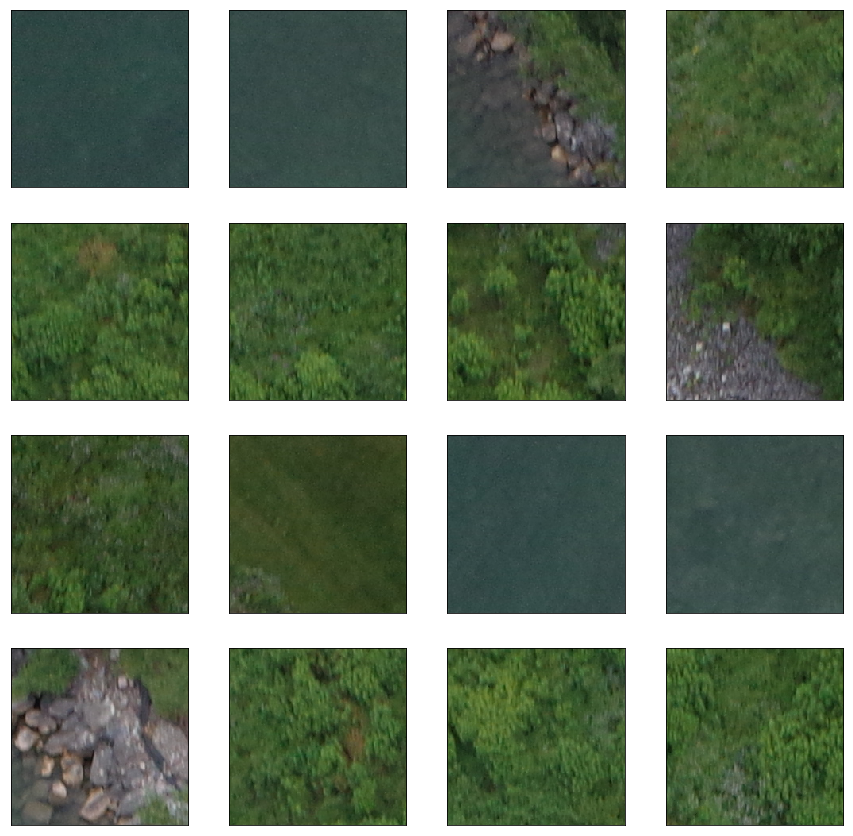

In [21]:
fig, ax = plt.subplots(4,4)
fig.set_figheight(15)
fig.set_figwidth(15)
for i, axi in enumerate(ax.flat):
    axi.imshow(Z[i])
    axi.set(xticks=[], yticks=[])

Step 4: For each window, estimate the class. This takes a couple of minutes

In [22]:
for i in range(len(Z)):
   w1.append(getCP(Z[i], graph))

Step 5: Create output arrays, filter out tiles with low probabilities

In [23]:
##C=most likely, P=prob
C, P = zip(*w1)

C = np.asarray(C)
P = np.asarray(P)

C = C+1 #add 1 so all labels are >=1

## create images with classes and probabilities
Lc = np.zeros((nx, ny))
Lp = np.zeros((nx, ny))

mn = np.int(tile-(tile*winprop)) #tile/2 - tile/4)
mx = np.int(tile+(tile*winprop)) #tile/2 + tile/4)

for k in range(len(Zx)): 
   Lc[Zx[k][mn:mx,mn:mx], Zy[k][mn:mx,mn:mx]] = Lc[Zx[k][mn:mx,mn:mx], Zy[k][mn:mx,mn:mx]]+C[k] 
   Lp[Zx[k][mn:mx,mn:mx], Zy[k][mn:mx,mn:mx]] = Lp[Zx[k][mn:mx,mn:mx], Zy[k][mn:mx,mn:mx]]+P[k] 
     
Lp = Lp[:nxo, :nyo]      
Lc = Lc[:nxo, :nyo]

Step 6: filter out low probabilities (according to ```prob_thres```)

In [24]:
Lcorig = Lc.copy()
Lcorig[Lp < prob_thres] = np.nan

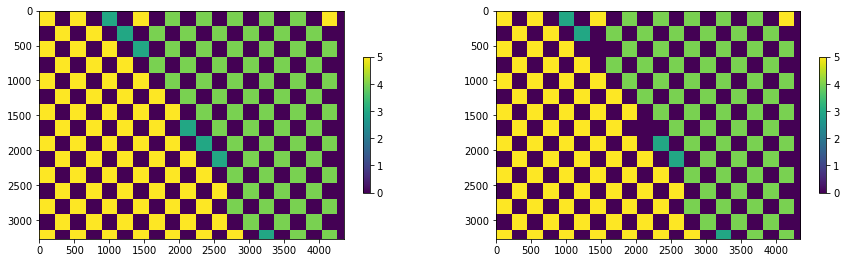

In [25]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(Lc)
plt.colorbar(shrink=0.25)

Lc[np.isnan(Lcorig)] = 0

plt.subplot(122)
plt.imshow(Lc)
plt.colorbar(shrink=0.25)

Step 7: We're going to resize to speed things up a little in the next step (CRF)

In [26]:
imgr = imresize(img, fct)
Lcr = np.round(imresize(Lc, fct, interp='nearest')/255 * np.max(Lc))

In [27]:
print(np.shape(imgr))
print(np.shape(Lcr))

(816, 1088, 3)
(816, 1088)


Step 8: Conditional Random Field post-processing. This takes a couple of minutes

In [28]:
print('CRF ... ')
res = getCRF(imgr, Lcr.astype('int'), theta, n_iter, labels, compat_spat, compat_col, scale, prob)

del imgr
resr = np.round(imresize(res, 1/fct, interp='nearest')/255 * np.max(res))
   
code1 = np.unique(res)
code2 = np.unique(resr)   
resrr = np.zeros(np.shape(resr), dtype='int8')
for kk in range(len(code1)):
   resrr[resr==code2[kk]] = code1[kk]   
   
del res, resr

CRF ... 


### Plot Result

Lastly, we can plot the result

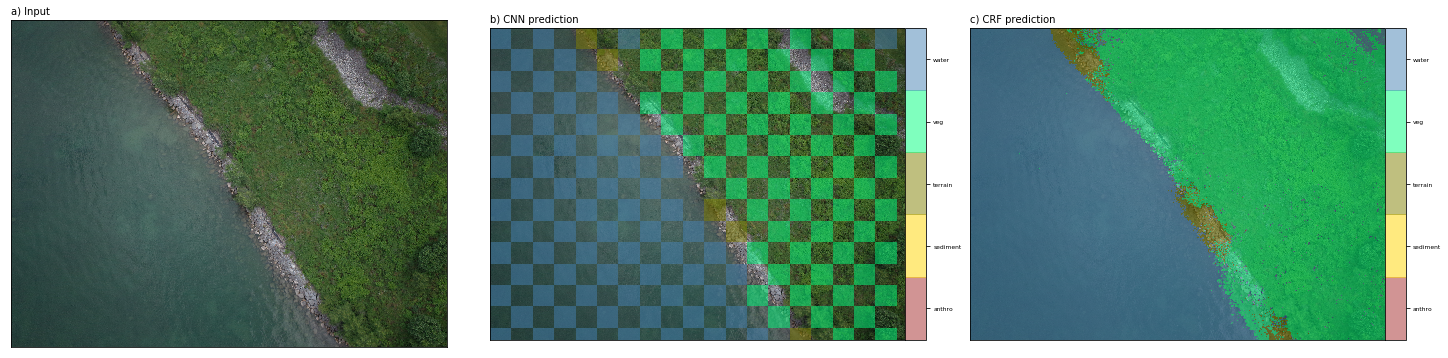

In [29]:
fig = plt.figure(figsize=(25,15))
fig.subplots_adjust(wspace=0.1)
ax1 = fig.add_subplot(131)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

im = ax1.imshow(img)
plt.title('a) Input', loc='left', fontsize=10)

ax1 = fig.add_subplot(132)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

im = ax1.imshow(img)
plt.title('b) CNN prediction', loc='left', fontsize=10)
im2 = ax1.imshow(Lcorig-1, cmap=cmap1, alpha=0.5, vmin=0, vmax=len(labels))
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%")
cb=plt.colorbar(im2, cax=cax)
cb.set_ticks(.5+np.arange(len(labels)+1)) 
cb.ax.set_yticklabels(labels)
cb.ax.tick_params(labelsize=6) 
plt.axis('tight')

ax1 = fig.add_subplot(133)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

im = ax1.imshow(img)
plt.title('c) CRF prediction', loc='left', fontsize=10)
im2 = ax1.imshow(resrr, cmap=cmap1, alpha=0.5, vmin=0, vmax=len(labels))
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%")
cb=plt.colorbar(im2, cax=cax)
cb.set_ticks(.5+np.arange(len(labels)+1)) 
cb.ax.set_yticklabels(labels)
cb.ax.tick_params(labelsize=6)  

This isn't bad considering we only trained our classifier on a 10th of available data (to save time)

To get a better prediction usually involves one of the following (in usual order of importance):
    
1. Training on more data / optimizing training parameters
2. Careful selection of tile size for the data set
3. Number of tiles to use (```decim``` parameter)
4. Othe input parameters

For the Ontario (and many other) datasets, we have a pretrained classifier, trained on more data. Let's use that one and compare the semantic segmentation results

### Download a pretrained model file from Google drive

All the data for this workshop is on a google drive located here: https://drive.google.com/drive/folders/1IhStVBhWMKLZUWIprti6zZyOg32-W4Of?usp=sharing


First we'll write a function to do this

In [30]:
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

Next we'll create a new directory to put our downloads

In [31]:
destination = 'gdrive_downloads'
import os
os.mkdir(destination)

The file id for this particular pretrained model is

https://drive.google.com/open?id=1lLjayLPILSfEUji-lh_d5lydb4voWzhU
    
You'll need the part after ```id=```    

In [32]:
file_id = '1lLjayLPILSfEUji-lh_d5lydb4voWzhU'

classifier_file = destination+os.sep+'ontario224_gdrive.pb'

download_file_from_google_drive(file_id, classifier_file)

To make things easier, we can use the ```semseg_cnn_crf.py``` file provided which does the same thing as above

In [33]:
%run ./semseg_cnn_crf.py $testimage $classifier_file $labels_path $colors_path $tile $prob_thres $prob $decim $fct

Image file: esipfed/cdi-workshop/semseg_data/ontario/test/A2013218_geotag.JPG
Graph file: gdrive_downloads/ontario224_gdrive.pb
Labels file: ontario_labels.txt
Colors file: ontario_colors.txt
Tile size: 224
Prob threshold: 0.5
Probability of DCNN class: 0.5
Decimation factor: 2
Image resize factor for CRF: 0.25
CNN ... 
CRF ... 
Writing png file
Writing mat file
Done!


<Figure size 432x288 with 0 Axes>

How does this result compare to the result we generated before, using the model trained on less data?

The function will print an image showing the results, and will also create a .mat file which contains the results of the classification. 

(yes, the same format as matlab)

Let's take a look at the contents of this file

In [34]:
from scipy.io import loadmat
dat = loadmat('A2013218_geotag_ares_224.mat')

# dat is a dictionary object
dat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'sparse', 'class', 'labels'])

What are these variables?

1. ```sparse```
    * the DCNN-derived unary potentials
2. ```class```
    * the pixelwise label
3. ```labels```
    * the class names

We can plot the pixelwise classification like so:

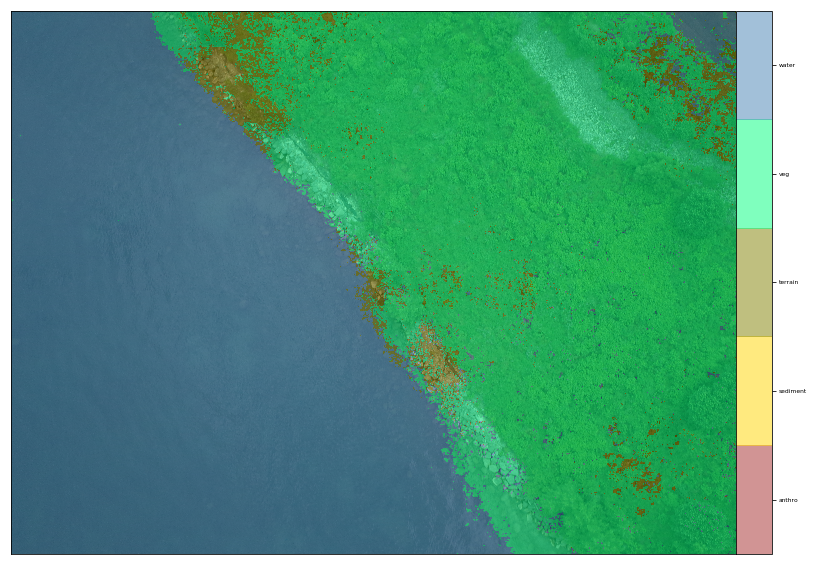

In [35]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(111)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

im = ax1.imshow(img)
im2 = ax1.imshow(dat['class'], cmap=cmap1, alpha=0.5, vmin=0, vmax=len(labels))
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%")
cb=plt.colorbar(im2, cax=cax)
cb.set_ticks(.5+np.arange(len(labels)+1)) 
cb.ax.set_yticklabels(labels)
cb.ax.tick_params(labelsize=6)  

We can also write out a label image. To do this we need to convert our color codes into RGB values

In [36]:
from collections import namedtuple
hexcol = [col.lstrip('#').split('\n')[0] for col in cols]
Label = namedtuple('Label', ['name', 'color'])

In [37]:
rgb = [tuple(int(h[i:i+2], 16) for i in (0, 2 ,4)) for h in hexcol]

label_defs = []
for k in range(len(labels)):
   label_defs.append(Label(labels[k],(rgb[k][0], rgb[k][1], rgb[k][2])))

In [38]:
label_defs

[Label(name='anthro', color=(165, 42, 42)),
 Label(name='sediment', color=(255, 215, 0)),
 Label(name='terrain', color=(128, 128, 0)),
 Label(name='veg', color=(0, 255, 127)),
 Label(name='water', color=(70, 130, 180))]

Create a 3-channel array and fill with red, green and blue values

In [39]:
out = np.zeros((np.shape(dat['class'])[0], np.shape(dat['class'])[1], 3), dtype='uint8')
for k in np.unique(dat['class']):
    out[:,:,0][dat['class']==k] = label_defs[k].color[0]
    out[:,:,1][dat['class']==k] = label_defs[k].color[1]
    out[:,:,2][dat['class']==k] = label_defs[k].color[2]

And finally write the RGB image to file

In [40]:
from imageio import imwrite
name, ext = os.path.splitext(testimage)
name = name.split(os.sep)[-1] 
imwrite(name+'_gtFine_color.png', out)

### Tidying up

In [41]:
!rm A2013218_geotag_ares_224.mat
!rm A2013218_geotag_ares_224.png
!rm A2013218_geotag_gtFine_color.png
!rm ontario_colors.txt
!rm ontario_labels.txt
!rm ontario_test_mobilenetv2_224_1000_0.01.pb

In [42]:
!rm -rf S3data_tile_224/

### CRF video

If you would like to know more about conditional random fields, here's a video

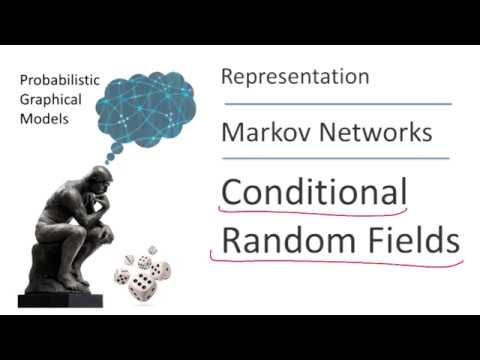

In [43]:
from IPython.display import YouTubeVideo
### conditional random fields
YouTubeVideo("rc3YDj5GiVM") ##22 mins

## Exercise

1. Read a local file in (such as one in ```ccr_test```) and carry out a semantic segmentation with the appropriate retrained model

There are lots of [named colors](https://matplotlib.org/examples/color/named_colors.html) within matplotlib

### Tidy up

In [44]:
!rm ccr_colors.txt
!rm ccr_labels.txt
!rm ccr_mobilenetv2_224_1000_0.01_ft.pb
!rm ccr_test_mobilenetv2_224_1000_0.01.pb
!rm -rf gdrive_downloads

rm: cannot remove 'ccr_colors.txt': No such file or directory


## DL-tools

The equivalent function in DL-tools is called and is the same as used here, i.e.

```python semseg_crf\semseg_cnn_crf.py testimage classifier_file labels_path colors_path tile prob_thres prob decim fct```